# 2022-08-05 • Spiketrain correlations (of unconnected-but-detected)

## Imports

In [1]:
#

In [2]:
using Revise

In [3]:
using MyToolbox

In [4]:
using VoltoMapSim

[ Info: Precompiling VoltoMapSim [f713100b-c48c-421a-b480-5fcb4c589a9e]


## Params

Based on Roxin; same as previous nb's.

In [6]:
d = 6
p = get_params(
    duration = 10minutes,
    p_conn = 0.04,
    g_EE = 1   / d,
    g_EI = 18  / d,
    g_IE = 36  / d,
    g_II = 31  / d,
    ext_current = Normal(-0.5 * pA/√seconds, 5 * pA/√seconds),
    E_inh = -80 * mV,
    record_v = [1, 801],
);

## Run sim

In [7]:
s = cached(sim, [p.sim]);

Running simulation: 100%|███████████████████████████████| Time: 0:11:16mmmm
Saving output at `C:\Users\tfiers\.phdcache\datamodel v2 (net)\sim\ebefdc43edf54e31.jld2` … done (29.6 s)


In [8]:
s = augment_simdata(s, p);

## Bin spiketrains

In [90]:
function bin(spiketimes; binsize, duration)
    # `spiketimes` is assumed sorted.
    # `duration` is of the spiketimes signal and determines the number of bins.
    num_bins = ceil(Int, duration / binsize)
    spikecounts = fill(0, num_bins)
    # loop counters:
    spike = 1
    bin_end_time = binsize
    for bin in 1:num_bins
        while spiketimes[spike] < bin_end_time
            spikecounts[bin] += 1
            spike += 1
            if spike > length(spiketimes)
                return spikecounts
            end
        end
        bin_end_time += binsize
    end
end;

### Test

In [71]:
events = s.spike_times[1][1:10]
show(events)

[0.685, 1.9, 2.8, 6.86, 8.55, 8.65, 13.4, 15.3, 16.9, 17.1]

In [72]:
show(bin(events; duration=20, binsize=2))

[2, 1, 0, 1, 2, 0, 1, 1, 2, 0]

Looks good

### Apply

In [73]:
p.conntest.STA_window_length / ms

100

In [85]:
binned_spikes = [bin(s.spike_times[n], duration = 10minutes, binsize = 100ms) for n in s.neuron_IDs];

## Correlation with recorded neuron

In [75]:
m = 1;  # analyzed neuron

In [87]:
cors = [cor(binned_spikes[m], binned_spikes[n]) for n in s.neuron_IDs];  # Pearson corr

## Split neurons by type

In [77]:
v = s.signals[m].v
ii = get_input_info(m, s, p);
ii.num_inputs

(exc = 26, inh = 10)

In [82]:
perf = cached(evaluate_conntest_perf, [v, ii.spiketrains, p], key = [p, m]);

Testing connections: 100%|██████████████████████████████| Time: 0:01:00
Saving output at `C:\Users\tfiers\.phdcache\datamodel v2 (net)\evaluate_conntest_perf\86c598a20b08f8eb.jld2` … done (4.3 s)


In [79]:
perf.detection_rates

(TPR_exc = 0.154, TPR_inh = 1, FPR = 0.15)

In [80]:
signif_unconn = ii.unconnected_neurons[findall(perf.p_values.unconn .< p.evaluation.α)];
tested_unconn = ii.unconnected_neurons[1:p.evaluation.N_tested_presyn]
insignif_unconn = [n for n in tested_unconn if n ∉ signif_unconn];

In [81]:
length(signif_unconn), length(insignif_unconn)

(6, 34)

## Plot

In [26]:
using PyPlot

In [27]:
using VoltoMapSim.Plot

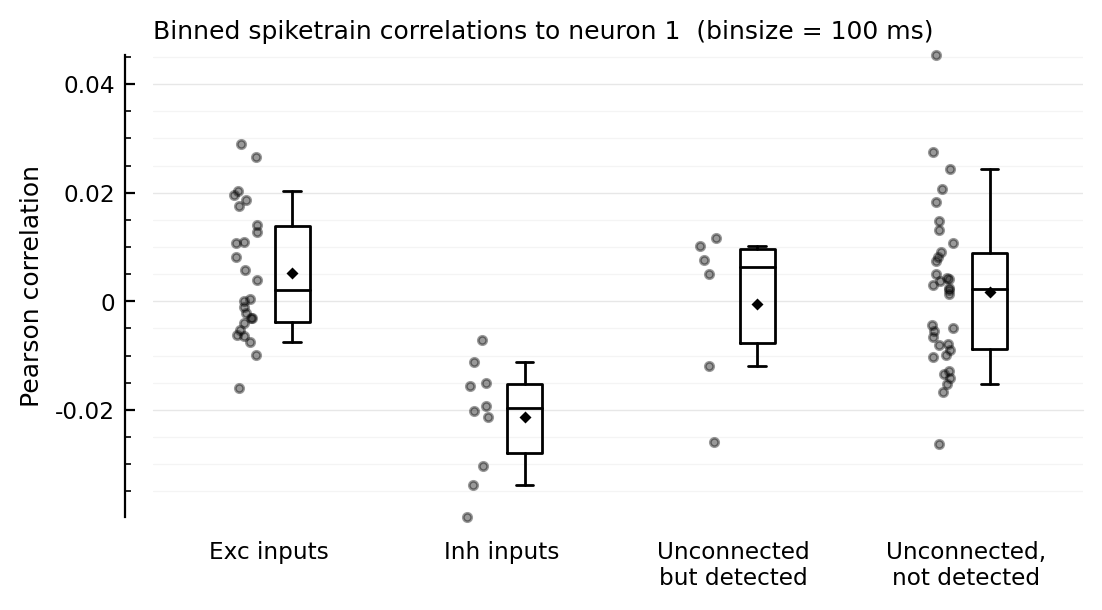

In [105]:
plotcors(cors, binsize_ms) = ydistplot(
    "Exc inputs" => cors[ii.exc_inputs],
    "Inh inputs" => cors[ii.inh_inputs],
    "Unconnected\nbut detected" => cors[signif_unconn],
    "Unconnected,\nnot detected" => cors[insignif_unconn],
    figsize = (6, 3),
    hylabel = "Binned spiketrain correlations to neuron $m  (binsize = $(binsize_ms) ms)",
    ylabel = "Pearson correlation",
#     ylim = [-0.04, +0.045],
)
plotcors(cors, 100);

## More bin sizes

In [106]:
function plotcors_for(; binsize)
    binned_spikes = [bin(s.spike_times[n], duration = 10minutes; binsize) for n in s.neuron_IDs]
    cors = [cor(binned_spikes[m], binned_spikes[n]) for n in s.neuron_IDs]
    plotcors(cors, binsize/ms)
end;

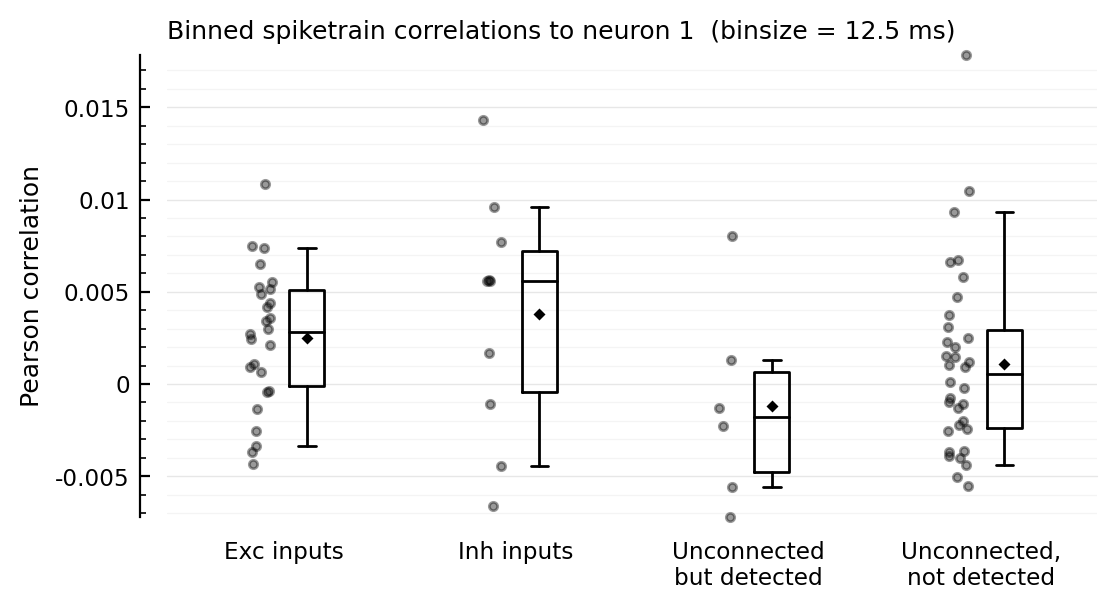

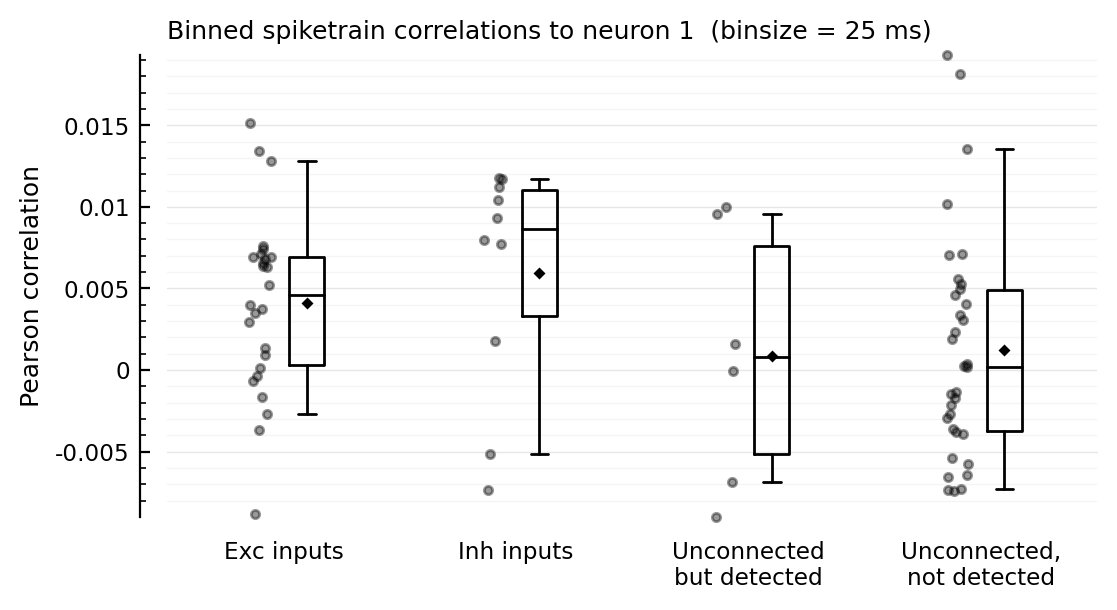

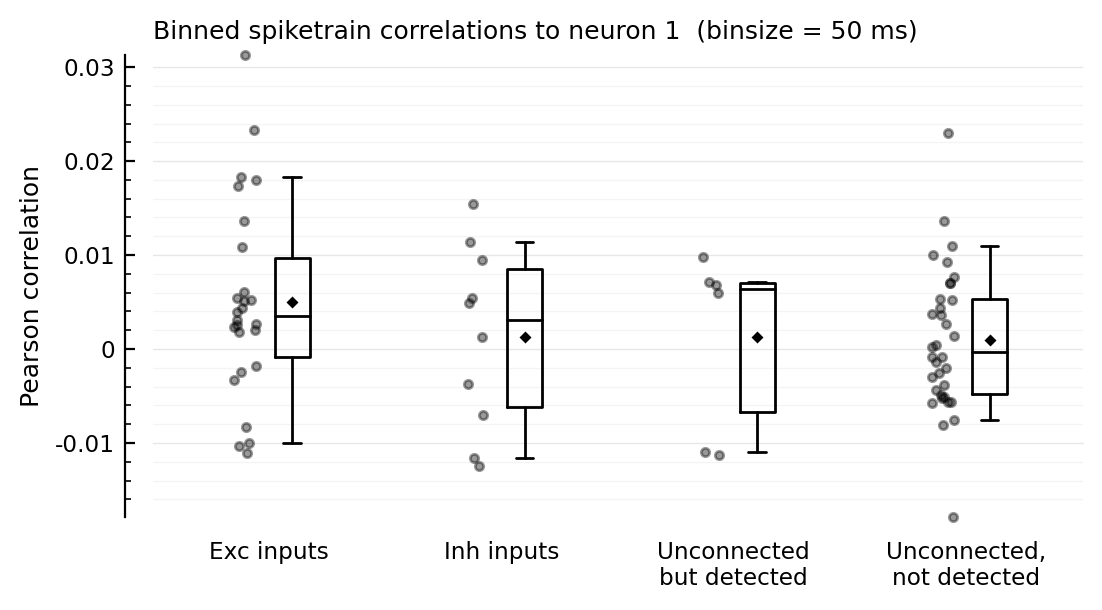

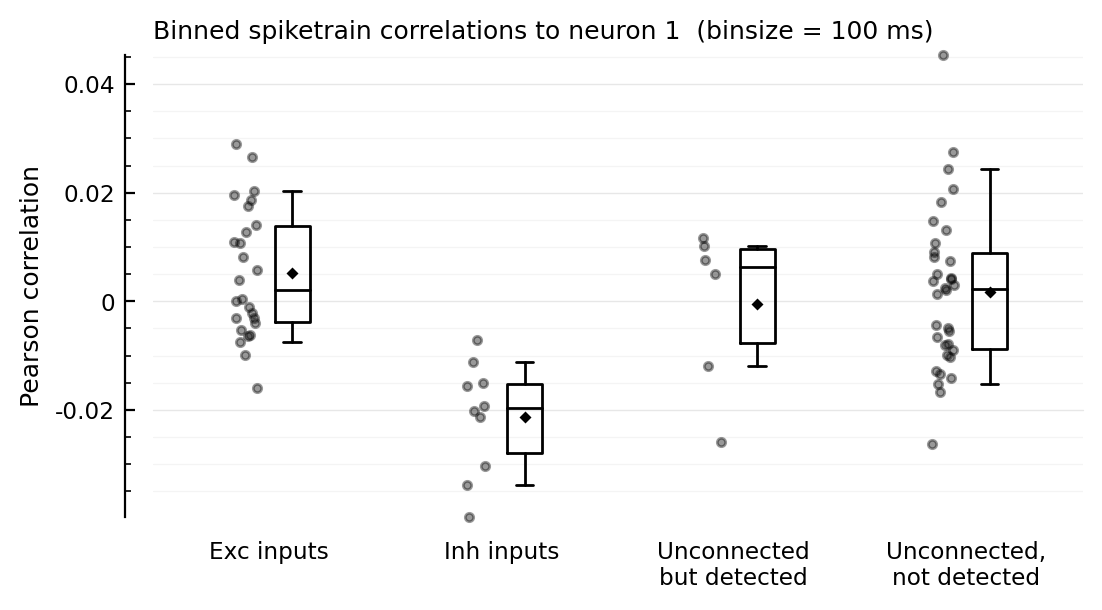

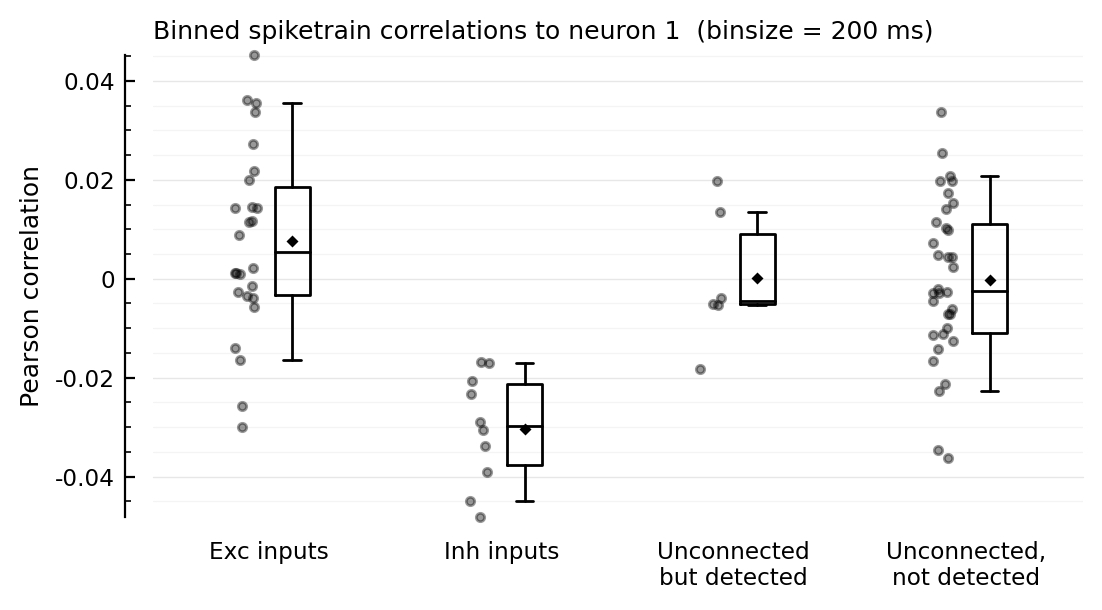

In [107]:
for binsize in [12.5, 25, 50, 100, 200] * ms
    plotcors_for(; binsize)
end;